In [2]:
from plot_helpers import *
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats 
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
from scipy.stats import linregress
import seaborn as sns
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter


# Set global font sizes - for manuscript
mpl.rcParams['font.size'] = 28
mpl.rcParams['axes.labelsize'] = 28
mpl.rcParams['xtick.labelsize'] = 38
mpl.rcParams['ytick.labelsize'] = 38
mpl.rcParams['legend.fontsize'] = 34



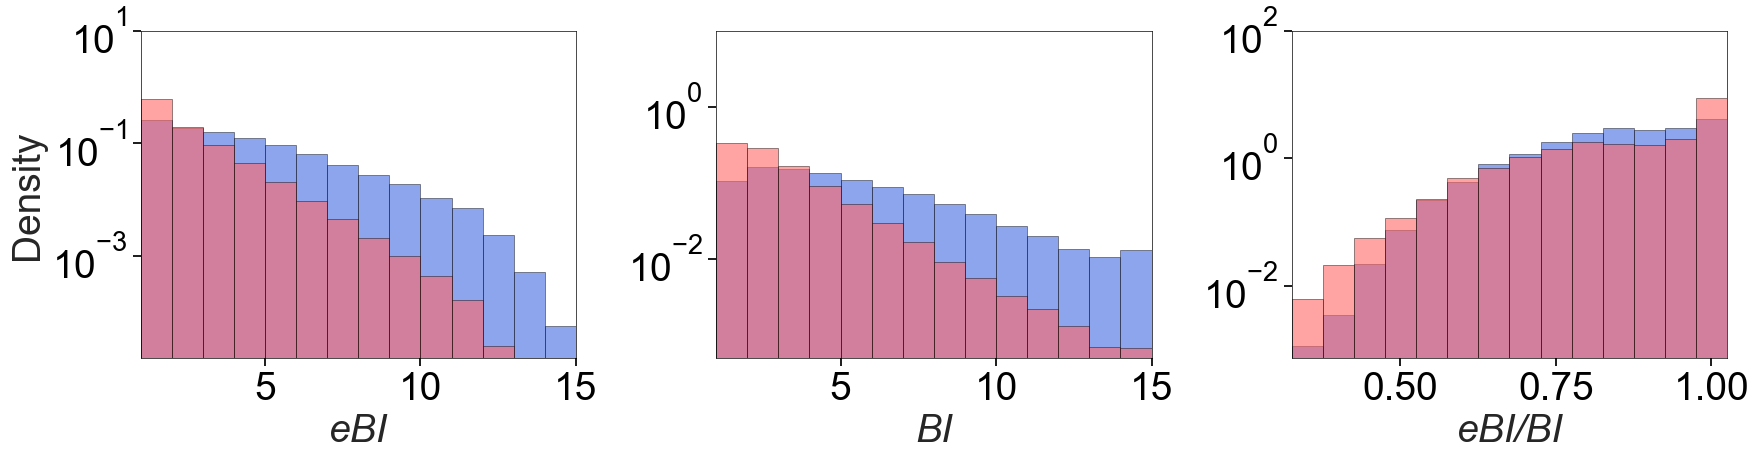

In [148]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np


root_dir = r'C:\Users\Feifei\Box\BR_remote_sensing\ebi_results'
obs_list = []

for river_folder in os.listdir(root_dir):
    river_path = os.path.join(root_dir, river_folder)
    if os.path.isdir(river_path):
        rivgraph_path = os.path.join(river_path, 'rivgraph')
        if os.path.isdir(rivgraph_path):
            ebi_annual_file = os.path.join(rivgraph_path, 'eBI_results_annual.csv')
            bi_annual_file = os.path.join(rivgraph_path, 'BI_results_annual.csv')
            
            if os.path.exists(ebi_annual_file) and os.path.exists(bi_annual_file):
                try:
                    ebi_df = pd.read_csv(ebi_annual_file)
                    bi_df = pd.read_csv(bi_annual_file)
                except Exception as e:
                    print(f"Error reading annual files for {river_folder}: {e}")
                    continue
                
                # Merge eBI and BI data on [Year, Cross_section]
                merged_df = pd.merge(ebi_df, bi_df, on=['Year', 'Cross_section'], how='inner')
                merged_df['River'] = river_folder
                obs_list.append(merged_df)
            else:
                print(f"Missing annual files for river {river_folder}.")

if obs_list:
    all_obs_df = pd.concat(obs_list, ignore_index=True)
else:
    print("No observations found.")
    all_obs_df = pd.DataFrame()

# --- Step 2. Load classification info from combined statistics CSV ---
combined_stats_path = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_combined_statistics.csv"
try:
    df_stats = pd.read_csv(combined_stats_path, usecols=['River', 'Classification'])
except Exception as e:
    print(f"Error reading combined statistics file: {e}")
    df_stats = pd.DataFrame()

merged_obs_df = pd.merge(all_obs_df, df_stats, on='River', how='left')

# --- Step 3. Compute eBI/BI ratio for each observation ---
merged_obs_df['ratio'] = merged_obs_df['eBI'] / merged_obs_df['BI']

# --- Step 4. Split data into Braided and Wandering groups ---
braided_obs = merged_obs_df[merged_obs_df['Classification'] == 'B']
wandering_obs = merged_obs_df[merged_obs_df['Classification'].isin(['HSW', 'LSW'])]

# Remove any data where eBI > 15 or BI > 15 for both braided and wandering
braided_obs = braided_obs[(braided_obs['eBI'] <= 15) & (braided_obs['BI'] <= 15)]
wandering_obs = wandering_obs[(wandering_obs['eBI'] <= 15) & (wandering_obs['BI'] <= 15)]

# --- Step 5. Plot combined histograms for eBI, BI, and eBI/BI ratio ---
colors = {'B': '#4169E1', 'Wandering': '#FF6666'}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Define bins of size 1 for eBI and BI (from 1 to 15)
bins_1_to_15 = range(1, 16)

# 1) eBI histogram
axes[0].hist(
    braided_obs['eBI'], bins=bins_1_to_15, 
    edgecolor='black', linewidth=0.5,  # thinner bin edges
    alpha=0.6, density=True, color=colors['B'], 
    label=f'Braided (n={len(braided_obs["eBI"])})'
)
axes[0].hist(
    wandering_obs['eBI'], bins=bins_1_to_15, 
    edgecolor='black', linewidth=0.5,  # thinner bin edges
    alpha=0.6, density=True, color=colors['Wandering'], 
    label=f'Wandering (n={len(wandering_obs["eBI"])})'
)
axes[0].set_xlabel('eBI', fontstyle='italic')
axes[0].set_ylabel('Density')
axes[0].set_yscale('log')
axes[0].set_xlim(1, 15)
axes[0].set_ylim(top=10)

# 2) BI histogram
axes[1].hist(
    braided_obs['BI'], bins=bins_1_to_15, 
    edgecolor='black', linewidth=0.5,  # thinner bin edges
    alpha=0.6, density=True, color=colors['B'], 
    label=f'Braided (n={len(braided_obs["BI"])})'
)
axes[1].hist(
    wandering_obs['BI'], bins=bins_1_to_15, 
    edgecolor='black', linewidth=0.5,  # thinner bin edges
    alpha=0.6, density=True, color=colors['Wandering'], 
    label=f'Wandering (n={len(wandering_obs["BI"])})'
)
axes[1].set_xlabel('BI', fontstyle='italic')
axes[1].set_yscale('log')
axes[1].set_xlim(1, 15)
axes[1].set_ylim(top=10)

# 3) eBI/BI ratio histogram
# Determine the overall min and max for the ratio from both datasets.
min_ratio = min(braided_obs['ratio'].min(), wandering_obs['ratio'].min())
max_ratio = max(braided_obs['ratio'].max(), wandering_obs['ratio'].max())

hist_bins = np.arange(min_ratio, max_ratio + 0.05, 0.05)
axes[2].hist(
    braided_obs['ratio'], bins=hist_bins, 
    edgecolor='black', linewidth=0.5,  # thinner bin edges
    alpha=0.6, density=True, color=colors['B'], 
    label=f'Braided (n={len(braided_obs["ratio"])})'
)
axes[2].hist(
    wandering_obs['ratio'], bins=hist_bins, 
    edgecolor='black', linewidth=0.5,  # thinner bin edges
    alpha=0.6, density=True, color=colors['Wandering'], 
    label=f'Wandering (n={len(wandering_obs["ratio"])})'
)
axes[2].set_xlabel('eBI/BI', fontstyle='italic')
axes[2].set_yscale('log')
axes[2].set_ylim(top=100)
axes[2].set_xlim(hist_bins[0], hist_bins[-1])

# Adjust spines and tick params
for ax in axes:
    ax.grid(False)
    # Make spines thinner
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)   # thinner subplot outline
    
    # Ticks
    ax.tick_params(
        axis='both', which='both',
        direction='out', colors='black',
        bottom=True, left=True
    )

plt.tight_layout()
plt.show()



fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\3_histograms.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)


### Supporting Information

In [8]:

Galeazzi_file = r"C:\Users\Feifei\Box\BR_remote_sensing\Galeazzi_eBI.csv"
df = pd.read_csv(Galeazzi_file)

df['discharge_start'] = pd.to_numeric(df['discharge_start'], errors='coerce')
df['discharge_end']   = pd.to_numeric(df['discharge_end'],   errors='coerce')

WIN_START, WIN_END = 1985, 2023
TOTAL_YEARS        = WIN_END - WIN_START + 1          # 39 years
MIN_YEARS          = math.ceil(0.8 * TOTAL_YEARS)    # 36 years (strictly > 90 %)


df['overlap_years'] = (
    np.minimum(df['discharge_end'],   WIN_END) -
    np.maximum(df['discharge_start'], WIN_START) + 1
)

# Rows with NaN years or negative overlap get invalid (≤0) values
df.loc[df['overlap_years'] < 0, 'overlap_years'] = 0

# ------------------------------------------------------------
# 5. Count unique rivers whose overlap ≥ threshold
# ------------------------------------------------------------
river_count = (
    df.loc[df['overlap_years'] >= MIN_YEARS, 'River_Station']
      .dropna()
      .nunique()
)

print(f"{river_count} rivers span >90 % ({MIN_YEARS}+ years) of the 1985–2023 window.")



36 rivers span >90 % (32+ years) of the 1985–2023 window.


In [3]:
# Load the statistics CSV file
combined_statistics_path = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_combined_statistics.csv"
df = pd.read_csv(combined_statistics_path)

# other File paths
root_dir = r'C:\Users\Feifei\Box\BR_remote_sensing\ebi_results'

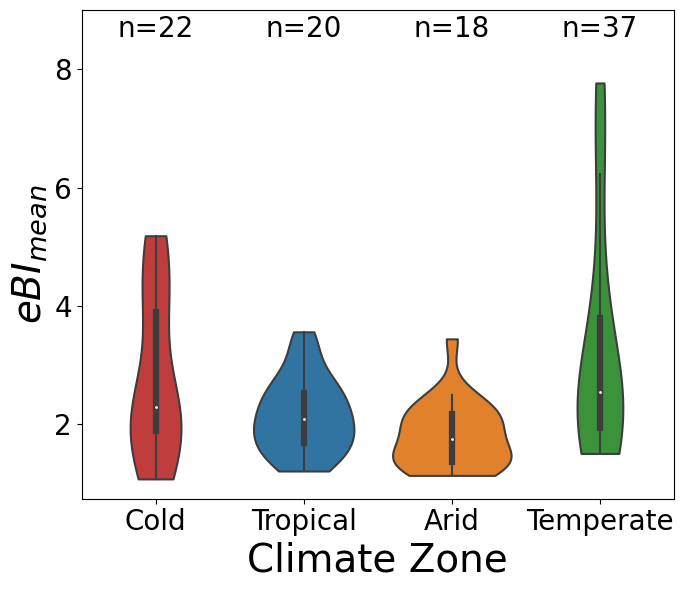

In [ ]:

# Climate zone mapping
climate_full_names = {
    'A': 'Tropical',
    'B': 'Arid',
    'C': 'Temperate',
    'D': 'Cold',
    'E': 'Polar'
}

# Full name color mapping
climate_colors_full = {
    'Tropical': '#1f77b4',  # Tropical (blue)
    'Arid': '#ff7f0e',      # Arid (orange)
    'Temperate': '#2ca02c', # Temperate (green)
    'Cold': '#d62728',      # Cold (red)
    'Polar': '#9467bd'      # Polar (purple)
}

# Extract the first letter from Climate Zone and map to full names
df['Climate Group'] = df['Climate Zone'].apply(lambda x: x[0] if isinstance(x, str) else None)
df['Climate Group Full Name'] = df['Climate Group'].map(climate_full_names)

# Calculate sample size for each Climate Group
sample_sizes = df.groupby('Climate Group Full Name').size()

# Create a figure for the violin plot
fig, ax = plt.subplots(figsize=(7, 6))

# Violin plot for all rivers
sns.violinplot(
    x='Climate Group Full Name', y='Mean_eBI_annual',
    data=df, palette=climate_colors_full, ax=ax, cut=0  # Set cut=0 to prevent extending beyond data range
)
ax.set_ylim(top=9)

# Add sample sizes as a single line above the violins
for i, climate in enumerate(sample_sizes.index):
    ax.text(i, ax.get_ylim()[1] * 0.95, f'n={sample_sizes[climate]}', 
            ha='center', fontsize=20, color='black')

# Set plot titles and labels
ax.set_xlabel('Climate Zone', fontsize=28)
ax.set_ylabel(r'${eBI_{mean}}$', fontsize=28)
ax.tick_params(axis='x', labelsize=20)  # Rotate for clarity
ax.tick_params(axis='y', labelsize=20)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\eBI_mean_boxplot.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)


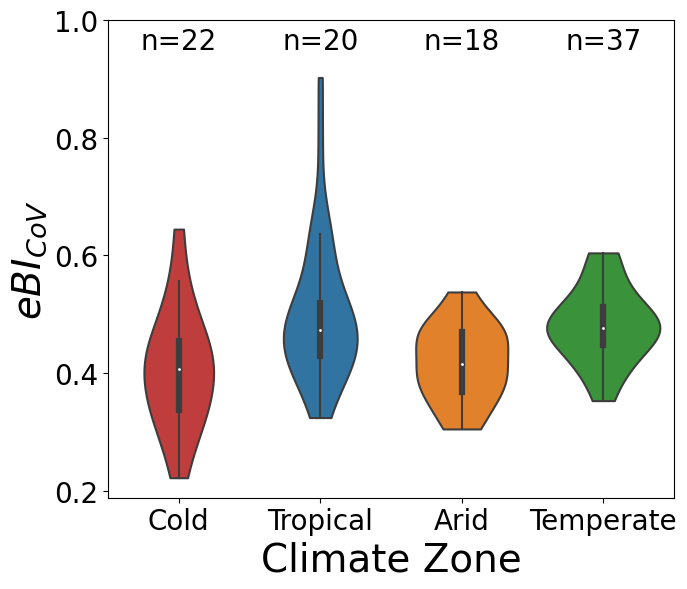

In [29]:
# Climate zone mapping
climate_full_names = {
    'A': 'Tropical',
    'B': 'Arid',
    'C': 'Temperate',
    'D': 'Cold',
    'E': 'Polar'
}

# Full name color mapping
climate_colors_full = {
    'Tropical': '#1f77b4',  # Tropical (blue)
    'Arid': '#ff7f0e',      # Arid (orange)
    'Temperate': '#2ca02c', # Temperate (green)
    'Cold': '#d62728',      # Cold (red)
    'Polar': '#9467bd'      # Polar (purple)
}

# Extract the first letter from Climate Zone and map to full names
df['Climate Group'] = df['Climate Zone'].apply(lambda x: x[0] if isinstance(x, str) else None)
df['Climate Group Full Name'] = df['Climate Group'].map(climate_full_names)

# Calculate sample size for each Climate Group
sample_sizes = df.groupby('Climate Group Full Name').size()

# Create a figure for the violin plot
fig, ax = plt.subplots(figsize=(7, 6))

# Violin plot for all rivers
sns.violinplot(
    x='Climate Group Full Name', y='cov_ebi_annual',
    data=df, palette=climate_colors_full, ax=ax, cut=0  # Set cut=0 to prevent extending beyond data range
)
ax.set_ylim(top=1)

# Add sample sizes as a single line above the violins
for i, climate in enumerate(sample_sizes.index):
    ax.text(i, ax.get_ylim()[1] * 0.95, f'n={sample_sizes[climate]}', 
            ha='center', fontsize=20, color='black')

# Set plot titles and labels
ax.set_xlabel('Climate Zone', fontsize=28)
ax.set_ylabel(r'${eBI_{CoV}}$', fontsize=28)
ax.tick_params(axis='x', labelsize=20)  # Rotate for clarity
ax.tick_params(axis='y', labelsize=20)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\3_eBI_cov_boxplot.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)


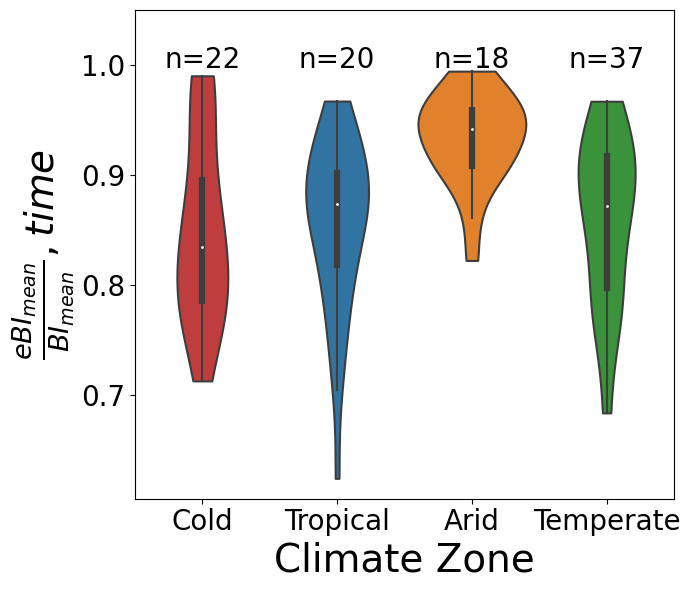

In [27]:
# Climate zone mapping
climate_full_names = {
    'A': 'Tropical',
    'B': 'Arid',
    'C': 'Temperate',
    'D': 'Cold',
    'E': 'Polar'
}

# Full name color mapping
climate_colors_full = {
    'Tropical': '#1f77b4',  # Tropical (blue)
    'Arid': '#ff7f0e',      # Arid (orange)
    'Temperate': '#2ca02c', # Temperate (green)
    'Cold': '#d62728',      # Cold (red)
    'Polar': '#9467bd'      # Polar (purple)
}

# Extract the first letter from Climate Zone and map to full names
df['Climate Group'] = df['Climate Zone'].apply(lambda x: x[0] if isinstance(x, str) else None)
df['Climate Group Full Name'] = df['Climate Group'].map(climate_full_names)

# Calculate sample size for each Climate Group
sample_sizes = df.groupby('Climate Group Full Name').size()

# Create a figure for the violin plot
fig, ax = plt.subplots(figsize=(7, 6))

# Violin plot for all rivers
sns.violinplot(
    x='Climate Group Full Name', y='eBI_BI_ratio_time',
    data=df, palette=climate_colors_full, ax=ax, cut=0  # Set cut=0 to prevent extending beyond data range
)
ax.set_ylim(top=1.05)

# Add sample sizes as a single line above the violins
for i, climate in enumerate(sample_sizes.index):
    ax.text(i, ax.get_ylim()[1] * 0.95, f'n={sample_sizes[climate]}', 
            ha='center', fontsize=20, color='black')

# Set plot titles and labels
ax.set_xlabel('Climate Zone', fontsize=28)
ax.set_ylabel(r'$\frac{eBI_{mean}}{BI_{mean}}, time$', fontsize=28)
ax.tick_params(axis='x', labelsize=20)  # Rotate for clarity
ax.tick_params(axis='y', labelsize=20)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\3_eBI_BImean_t_boxplot.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

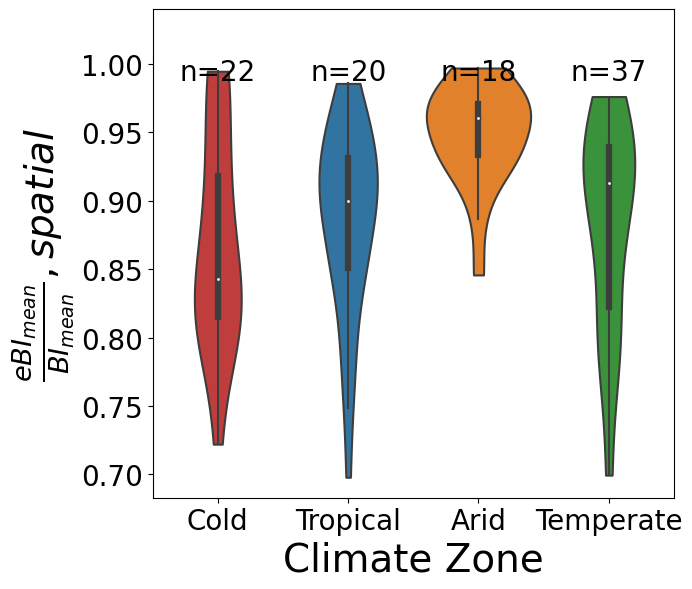

In [26]:
# Climate zone mapping
climate_full_names = {
    'A': 'Tropical',
    'B': 'Arid',
    'C': 'Temperate',
    'D': 'Cold',
    'E': 'Polar'
}

# Full name color mapping
climate_colors_full = {
    'Tropical': '#1f77b4',  # Tropical (blue)
    'Arid': '#ff7f0e',      # Arid (orange)
    'Temperate': '#2ca02c', # Temperate (green)
    'Cold': '#d62728',      # Cold (red)
    'Polar': '#9467bd'      # Polar (purple)
}

# Extract the first letter from Climate Zone and map to full names
df['Climate Group'] = df['Climate Zone'].apply(lambda x: x[0] if isinstance(x, str) else None)
df['Climate Group Full Name'] = df['Climate Group'].map(climate_full_names)

# Calculate sample size for each Climate Group
sample_sizes = df.groupby('Climate Group Full Name').size()

# Create a figure for the violin plot
fig, ax = plt.subplots(figsize=(7, 6))

# Violin plot for all rivers
sns.violinplot(
    x='Climate Group Full Name', y='eBI_BI_ratio_spatial',
    data=df, palette=climate_colors_full, ax=ax, cut=0  # Set cut=0 to prevent extending beyond data range
)
ax.set_ylim(top=1.04)

# Add sample sizes as a single line above the violins
for i, climate in enumerate(sample_sizes.index):
    ax.text(i, ax.get_ylim()[1] * 0.95, f'n={sample_sizes[climate]}', 
            ha='center', fontsize=20, color='black')

# Set plot titles and labels
ax.set_xlabel('Climate Zone', fontsize=28)
ax.set_ylabel(r'$\frac{eBI_{mean}}{BI_{mean}}, spatial$', fontsize=28)
ax.tick_params(axis='x', labelsize=20)  # Rotate for clarity
ax.tick_params(axis='y', labelsize=20)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\3_eBI_BI_s_boxplot.pdf", 
            format='pdf', dpi=500, bbox_inches='tight', transparent=True)

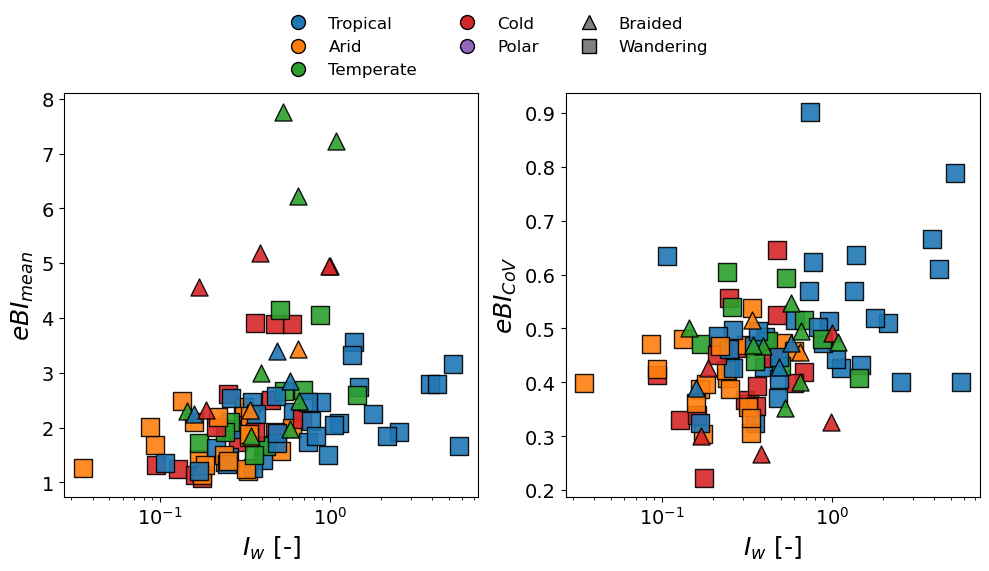

In [4]:
# Climate zone mapping with high-contrast colors
climate_full_names = {
    'A': 'Tropical',
    'B': 'Arid',
    'C': 'Temperate',
    'D': 'Cold',
    'E': 'Polar'
}

climate_colors = {
    'A': '#1f77b4',  # Tropical (blue)
    'B': '#ff7f0e',  # Arid (orange)
    'C': '#2ca02c',  # Temperate (green)
    'D': '#d62728',  # Cold (red)
    'E': '#9467bd'   # Polar (purple)
}

# Planform type mapping
markers = {'HSW': 's', 'LSW': 's', 'B': '^'}  # Combined HSW and LSW symbols
planform_type_labels = {'HSW': 'Wandering', 'LSW': 'Wandering', 'B': 'Braided'}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Function to get color based on climate group
def get_color(climate_class):
    if isinstance(climate_class, str) and climate_class:  # Ensure it's a valid string
        return climate_colors.get(climate_class[0], '#7f7f7f')  # Default to gray if unknown
    return '#7f7f7f'  # Default color for missing or invalid values

# Plot Intermittency Factor vs. Mean eBI Annual
for cls in ['HSW', 'LSW', 'B']:
    subset = df[df['Classification'] == cls]
    for _, row in subset.iterrows():
        climate_zone = row['Climate Zone']
        ax1.scatter(
            row['Iw'], row['Mean_eBI_annual'],
            marker=markers[cls], c=get_color(climate_zone),
            edgecolors='black', s=150, alpha=0.9
        )

# Plot Intermittency Factor vs. CoV eBI Annual
for cls in ['HSW', 'LSW', 'B']:
    subset = df[df['Classification'] == cls]
    for _, row in subset.iterrows():
        climate_zone = row['Climate Zone']
        ax2.scatter(
            row['Iw'], row['cov_ebi_annual'],
            marker=markers[cls], c=get_color(climate_zone),
            edgecolors='black', s=150, alpha=0.9
        )

# Create legends
# Climate legend
climate_legend = [
    Line2D([0], [0], marker='o', color='w', label=climate_full_names[group],
           markerfacecolor=color, markersize=10, markeredgecolor='black')
    for group, color in climate_colors.items()
]

# Planform type legend
planform_legend = [
    Line2D([0], [0], marker=markers['B'], color='w', label='Braided',
           markerfacecolor='gray', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker=markers['HSW'], color='w', label='Wandering',
           markerfacecolor='gray', markersize=10, markeredgecolor='black')
]

# Add legends
fig.legend(handles=climate_legend + planform_legend, loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=3, fontsize=12, frameon=False)

# Set labels and format
for ax in (ax1, ax2):
    ax.set_xlabel(r'${I_{w}}$ [-]', fontsize=18)  # Display fraction as LaTeX
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xscale('log')

ax1.set_ylabel(r'${eBI_{mean}}$', fontsize=18)
ax2.set_ylabel(r'${eBI_{CoV}}$', fontsize=18)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [5]:


# Map the 'Classification' column to two groups: 'braided' for 'B' and 'wandering' for 'LSW' and 'HSW'
df['river_type'] = df['Classification'].apply(lambda x: 'braided' if x == 'B' else 'wandering')

# Group the DataFrame by the new 'river_type' column
grouped = df.groupby('river_type')

for river, group in grouped:
    count_rivers = len(group)
    mean_Mean_eBI_annual = group['Mean_eBI_annual'].mean()
    mean_Median_eBI_annual = group['Median_eBI_annual'].mean()
    avg_cov_ebi_annual = group['cov_ebi_annual'].mean()
    avg_Mean_BI_annual = group['Mean_BI_annual'].mean()
    avg_Median_BI_annual = group['Median_BI_annual'].mean()
    avg_eBI_BI_ratio_time = group['eBI_BI_ratio_time'].mean()
    avg_eBI_BI_ratio_spatial = group['eBI_BI_ratio_spatial'].mean()

    print(f"Statistics for {river} rivers (count: {count_rivers}):")
    print(f"  Mean of Mean_eBI_annual: {mean_Mean_eBI_annual}")
    print(f"  Mean of Median_eBI_annual: {mean_Median_eBI_annual}")
    print(f"  Average cov_ebi_annual: {avg_cov_ebi_annual}")
    print(f"  Average Mean_BI_annual: {avg_Mean_BI_annual}")
    print(f"  Average Median_BI_annual: {avg_Median_BI_annual}")
    print(f"  Average eBI_BI_ratio_time: {avg_eBI_BI_ratio_time}")
    print(f"  Average eBI_BI_ratio_spatial: {avg_eBI_BI_ratio_spatial}")
    print("=" * 50)

Statistics for braided rivers (count: 18):
  Mean of Mean_eBI_annual: 3.837219144839328
  Mean of Median_eBI_annual: 3.6074394351080965
  Average cov_ebi_annual: 0.4326914430354313
  Average Mean_BI_annual: 4.589756394291189
  Average Median_BI_annual: 4.333333333333333
  Average eBI_BI_ratio_time: 0.8679499054264109
  Average eBI_BI_ratio_spatial: 0.8786832507290394
Statistics for wandering rivers (count: 79):
  Mean of Mean_eBI_annual: 2.079547076466892
  Mean of Median_eBI_annual: 1.8442639042891056
  Average cov_ebi_annual: 0.46444300493375884
  Average Mean_BI_annual: 2.4602338755849944
  Average Median_BI_annual: 2.1962025316455698
  Average eBI_BI_ratio_time: 0.8743221454355714
  Average eBI_BI_ratio_spatial: 0.900637600838668


In [6]:
import pandas as pd

# Assuming you've already loaded your DataFrame (df) and performed the climate mapping:
# Climate zone mapping
climate_full_names = {
    'A': 'Tropical',
    'B': 'Arid',
    'C': 'Temperate',
    'D': 'Cold',
    'E': 'Polar'
}

# Full name color mapping (not used in calculations, just provided)
climate_colors_full = {
    'Tropical': '#1f77b4',  # Tropical (blue)
    'Arid': '#ff7f0e',      # Arid (orange)
    'Temperate': '#2ca02c', # Temperate (green)
    'Cold': '#d62728',      # Cold (red)
    'Polar': '#9467bd'      # Polar (purple)
}

# Extract the first letter from 'Climate Zone' and map to full names
df['Climate Group'] = df['Climate Zone'].apply(lambda x: x[0] if isinstance(x, str) else None)
df['Climate Group Full Name'] = df['Climate Group'].map(climate_full_names)

# Group by 'Climate Group Full Name'
climate_groups = df.groupby('Climate Group Full Name')

# ---- Mean_eBI_annual ----
mean_eBI_stats = climate_groups['Mean_eBI_annual'].agg(['mean', 'std'])
print("Mean_eBI_annual statistics by Climate Zone:")
print(mean_eBI_stats)

# Determine highest, lowest, and most spread (highest std)
highest_mean_eBI = mean_eBI_stats['mean'].idxmax()
lowest_mean_eBI = mean_eBI_stats['mean'].idxmin()
most_spread_eBI = mean_eBI_stats['std'].idxmax()

print(f"\nFor Mean_eBI_annual:")
print(f"  Highest mean: {highest_mean_eBI} (mean = {mean_eBI_stats.loc[highest_mean_eBI, 'mean']})")
print(f"  Lowest mean: {lowest_mean_eBI} (mean = {mean_eBI_stats.loc[lowest_mean_eBI, 'mean']})")
print(f"  Most spread (highest std): {most_spread_eBI} (std = {mean_eBI_stats.loc[most_spread_eBI, 'std']})")

# ---- cov_ebi_annual ----
cov_stats = climate_groups['cov_ebi_annual'].agg(['mean', 'std'])
print("\n\ncov_ebi_annual statistics by Climate Zone:")
print(cov_stats)

highest_cov = cov_stats['mean'].idxmax()
lowest_cov = cov_stats['mean'].idxmin()

print(f"\nFor cov_ebi_annual:")
print(f"  Highest mean: {highest_cov} (mean = {cov_stats.loc[highest_cov, 'mean']})")
print(f"  Lowest mean: {lowest_cov} (mean = {cov_stats.loc[lowest_cov, 'mean']})")

# ---- eBI_BI_ratio_time ----
ebi_bi_time_stats = climate_groups['eBI_BI_ratio_time'].agg(['mean', 'std'])
print("\n\neBI_BI_ratio_time statistics by Climate Zone:")
print(ebi_bi_time_stats)

highest_ratio_time = ebi_bi_time_stats['mean'].idxmax()
lowest_ratio_time = ebi_bi_time_stats['mean'].idxmin()
most_spread_ratio_time = ebi_bi_time_stats['std'].idxmax()

print(f"\nFor eBI_BI_ratio_time:")
print(f"  Highest mean: {highest_ratio_time} (mean = {ebi_bi_time_stats.loc[highest_ratio_time, 'mean']})")
print(f"  Lowest mean: {lowest_ratio_time} (mean = {ebi_bi_time_stats.loc[lowest_ratio_time, 'mean']})")
print(f"  Most spread (highest std): {most_spread_ratio_time} (std = {ebi_bi_time_stats.loc[most_spread_ratio_time, 'std']})")

# ---- eBI_BI_ratio_spatial ----
ebi_bi_spatial_stats = climate_groups['eBI_BI_ratio_spatial'].agg(['mean', 'std'])
print("\n\neBI_BI_ratio_spatial statistics by Climate Zone:")
print(ebi_bi_spatial_stats)

highest_ratio_spatial = ebi_bi_spatial_stats['mean'].idxmax()
lowest_ratio_spatial = ebi_bi_spatial_stats['mean'].idxmin()
most_spread_ratio_spatial = ebi_bi_spatial_stats['std'].idxmax()

print(f"\nFor eBI_BI_ratio_spatial:")
print(f"  Highest mean: {highest_ratio_spatial} (mean = {ebi_bi_spatial_stats.loc[highest_ratio_spatial, 'mean']})")
print(f"  Lowest mean: {lowest_ratio_spatial} (mean = {ebi_bi_spatial_stats.loc[lowest_ratio_spatial, 'mean']})")
print(f"  Most spread (highest std): {most_spread_ratio_spatial} (std = {ebi_bi_spatial_stats.loc[most_spread_ratio_spatial, 'std']})")


Mean_eBI_annual statistics by Climate Zone:
                             mean       std
Climate Group Full Name                    
Arid                     1.816977  0.556803
Cold                     2.779796  1.383781
Temperate                3.216084  1.936269
Tropical                 2.159331  0.625960

For Mean_eBI_annual:
  Highest mean: Temperate (mean = 3.2160839090270863)
  Lowest mean: Arid (mean = 1.8169767681097149)
  Most spread (highest std): Temperate (std = 1.93626850177135)


cov_ebi_annual statistics by Climate Zone:
                             mean       std
Climate Group Full Name                    
Arid                     0.417221  0.064596
Cold                     0.407215  0.100834
Temperate                0.481810  0.064492
Tropical                 0.499559  0.118598

For cov_ebi_annual:
  Highest mean: Tropical (mean = 0.4995594094305099)
  Lowest mean: Cold (mean = 0.40721490694705953)


eBI_BI_ratio_time statistics by Climate Zone:
                        

In [7]:
# Map the 'Classification' column into two groups: 'braided' for 'B' and 'wandering' for 'LSW' and 'HSW'
df['river_type'] = df['Classification'].apply(lambda x: 'braided' if x == 'B' else 'wandering')

# Group the DataFrame by the new 'river_type' column
grouped = df.groupby('river_type')

# Iterate over each group and calculate min and max for 'Qm' and 'dim_Q'
for river, group in grouped:
    qm_min = group['Qm'].min()
    qm_max = group['Qm'].max()
    dim_q_min = group['dim_Q'].min()
    dim_q_max = group['dim_Q'].max()

    print(f"Statistics for {river} rivers:")
    print(f"  Qm: min = {qm_min}, max = {qm_max}")
    print(f"  dim_Q: min = {dim_q_min}, max = {dim_q_max}")
    print("=" * 40)

Statistics for braided rivers:
  Qm: min = 266, max = 21260
  dim_Q: min = 0.0067902324251322, max = 30.577002136761315
Statistics for wandering rivers:
  Qm: min = 126, max = 126066
  dim_Q: min = 0.0333838686884376, max = 45.29964898826032


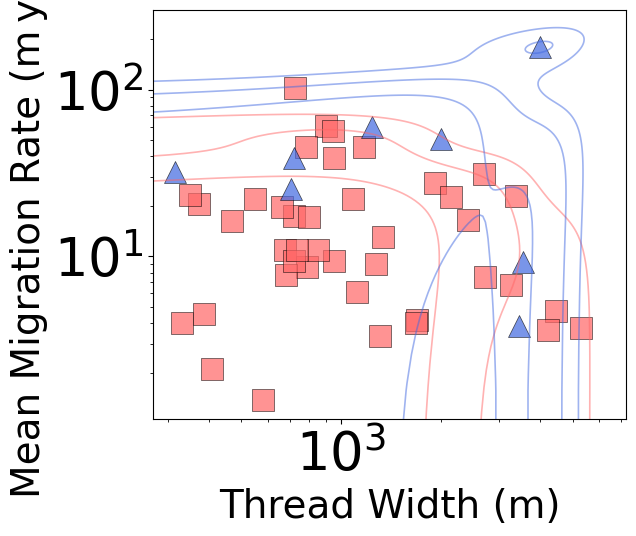

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# Load the statistics CSV file
combined_statistics_path = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_combined_statistics.csv"
df = pd.read_csv(combined_statistics_path)


# ------------------------------------------------------------------
# 1) Grouping exactly as in your original code
# ------------------------------------------------------------------
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

markers = {'Wandering': 's', 'B': '^'}
colors  = {'Wandering': '#FF6666', 'B': '#4169E1'}

# ------------------------------------------------------------------
# 2) Basic scatter
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 6))

for group in ['Wandering', 'B']:
    sub = df[df['Group'] == group]
    ax.scatter(
        sub['wetted_area_avg_subannual'], sub['mean_migration_rate'],
        marker = markers[group],
        c      = colors[group],
        edgecolors='black',
        s=250, alpha=0.7,
        linewidths=0.5,
        label=group
    )

# ------------------------------------------------------------------
# 3) Overlay 2‑D KDE contours (one per class)
# ------------------------------------------------------------------
for group in ['Wandering', 'B']:
    sub = df[df['Group'] == group]
    sns.kdeplot(
        x=sub['wetted_area_avg_subannual'], y=sub['mean_migration_rate'],
        ax=ax,
        levels=[0.1, 0.3, 0.6],       # 10 %, 30 %, 60 % probability contours
        color=colors[group],
        linewidths=1.2,
        alpha=0.5,
        fill=False,                   # set True if you prefer filled contours
        zorder=1                      # keep below the scatter markers
    )

# ------------------------------------------------------------------
# 4) Axes, legend, etc.
# ------------------------------------------------------------------
ax.set_xlabel('Thread Width (m)')
ax.set_ylabel('Mean Migration Rate (m yr⁻¹)')

# Pad limits a bit
x_pad = 0.1 * (df['wetted_area_avg_subannual'].max() - df['wetted_area_avg_subannual'].min())
y_pad = 0.1 * (df['mean_migration_rate'].max() - df['mean_migration_rate'].min())
#ax.set_xlim(df['wetted_area_avg_subannual'].min() - x_pad, df['wetted_area_avg_subannual'].max() + x_pad)
#ax.set_ylim(df['mean_migration_rate'].min() - y_pad, df['mean_migration_rate'].max() + y_pad)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(axis='both')

# Custom legend (no slope/R² this time)
legend_elems = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label='Wandering', markerfacecolor=colors['Wandering'],
           markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label='Braided', markerfacecolor=colors['B'],
           markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None')
]
#ax.legend(handles=legend_elems, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()



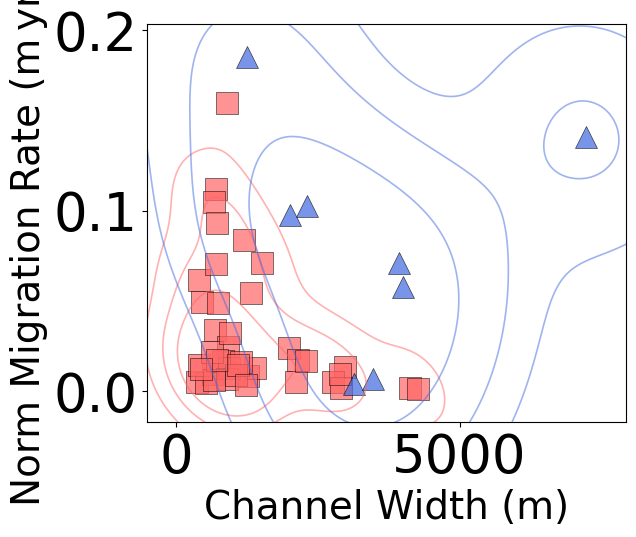

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# Load the statistics CSV file
combined_statistics_path = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_combined_statistics.csv"
df = pd.read_csv(combined_statistics_path)


# ------------------------------------------------------------------
# 1) Grouping exactly as in your original code
# ------------------------------------------------------------------
wandering_types = ['HSW', 'LSW']
df['Group'] = df['Classification'].replace(wandering_types, 'Wandering')

markers = {'Wandering': 's', 'B': '^'}
colors  = {'Wandering': '#FF6666', 'B': '#4169E1'}

# ------------------------------------------------------------------
# 2) Basic scatter
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 6))

for group in ['Wandering', 'B']:
    sub = df[df['Group'] == group]
    ax.scatter(
        sub['Width(m)'], sub['norm_migration_rate'],
        marker = markers[group],
        c      = colors[group],
        edgecolors='black',
        s=250, alpha=0.7,
        linewidths=0.5,
        label=group
    )

# ------------------------------------------------------------------
# 3) Overlay 2‑D KDE contours (one per class)
# ------------------------------------------------------------------
for group in ['Wandering', 'B']:
    sub = df[df['Group'] == group]
    sns.kdeplot(
        x=sub['Width(m)'], y=sub['norm_migration_rate'],
        ax=ax,
        levels=[0.1, 0.3, 0.6],       # 10 %, 30 %, 60 % probability contours
        color=colors[group],
        linewidths=1.2,
        alpha=0.5,
        fill=False,                   # set True if you prefer filled contours
        zorder=1                      # keep below the scatter markers
    )

# ------------------------------------------------------------------
# 4) Axes, legend, etc.
# ------------------------------------------------------------------
ax.set_xlabel('Channel Width (m)')
ax.set_ylabel('Norm Migration Rate (m yr⁻¹)')

# Pad limits a bit
x_pad = 0.1 * (df['Width(m)'].max() - df['Width(m)'].min())
y_pad = 0.1 * (df['norm_migration_rate'].max() - df['norm_migration_rate'].min())
ax.set_xlim(df['Width(m)'].min() - x_pad, df['Width(m)'].max() + x_pad)
ax.set_ylim(df['norm_migration_rate'].min() - y_pad, df['norm_migration_rate'].max() + y_pad)

ax.tick_params(axis='both')

# Custom legend (no slope/R² this time)
legend_elems = [
    Line2D([0], [0], marker=markers['Wandering'], color='w',
           label='Wandering', markerfacecolor=colors['Wandering'],
           markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None'),
    Line2D([0], [0], marker=markers['B'], color='w',
           label='Braided', markerfacecolor=colors['B'],
           markersize=15, markeredgecolor='black', markeredgewidth=0.5, linestyle='None')
]
#ax.legend(handles=legend_elems, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

